# Pneumonia Detection from Chest X-Ray Images 

In [ ]:
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import skimage
from skimage.transform import resize
from pathlib import Path
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from mlxtend.plotting import plot_confusion_matrix

import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D, Activation
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
import tensorflow as tf
from keras.applications.vgg16 import VGG16

Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

# Data

In [ ]:
# list of files in the data directory
print(os.listdir ("../chest_xray/chest_xray"))
print(os.listdir("../chest_xray/chest_xray/train"))
print(os.listdir("../chest_xray/chest_xray/test"))

['.DS_Store', 'test', 'train', 'val']
['.DS_Store', 'PNEUMONIA', 'NORMAL']
['.DS_Store', 'PNEUMONIA', 'NORMAL']


In [ ]:
train_p_dir = '../chest_xray/chest_xray/train/PNEUMONIA/'  # directory with our training PNEUMONIA pictures
train_n_dir = '../chest_xray/chest_xray/train/NORMAL/'  # directory with our training NORMAL pictures

# Show some normal and pneumonia images

In [ ]:
Pimages = os.listdir(train_p_dir)
Nimages = os.listdir(train_n_dir)

(Left) - No Pneumonia Vs (Right) - Pneumonia


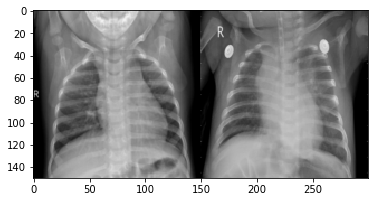

(Left) - No Pneumonia Vs (Right) - Pneumonia


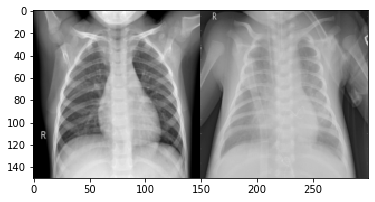

(Left) - No Pneumonia Vs (Right) - Pneumonia


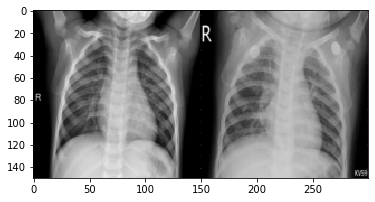

(Left) - No Pneumonia Vs (Right) - Pneumonia


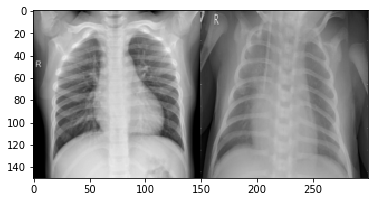

(Left) - No Pneumonia Vs (Right) - Pneumonia


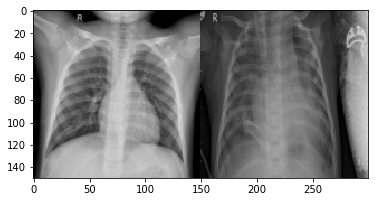

In [ ]:
def plotter(i):
    imagep1 = cv2.imread(train_p_dir+Pimages[i])
    imagep1 = skimage.transform.resize(imagep1, (150, 150, 3) , mode = 'reflect')
    imagen1 = cv2.imread(train_n_dir+Nimages[i])
    imagen1 = skimage.transform.resize(imagen1, (150, 150, 3))
    pair = np.concatenate((imagen1, imagep1), axis=1)
    print("(Left) - No Pneumonia Vs (Right) - Pneumonia")
    plt.figure(figsize=(6,4))
    plt.imshow(pair)
    plt.show()
for i in range(1,6):
    plotter(i)

In [ ]:
# Define path to the data directory
data_dir = Path('../chest_xray/chest_xray')

train_dir = data_dir / 'train'

val_dir = data_dir / 'val'

In [ ]:
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

In [ ]:
# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    train_data.append((img, 1))

train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)
train_data.head()

,image,label
0,../chest_xray/chest_xray/train/PNEUMONIA/perso...,1
1,../chest_xray/chest_xray/train/PNEUMONIA/perso...,1
2,../chest_xray/chest_xray/train/NORMAL/NORMAL2-...,0
3,../chest_xray/chest_xray/train/PNEUMONIA/perso...,1
4,../chest_xray/chest_xray/train/NORMAL/IM-0160-...,0


In [ ]:
# Get the counts for each class
cases_count = train_data['label'].value_counts()
print(cases_count)

1    3875
0    1341
Name: label, dtype: int64


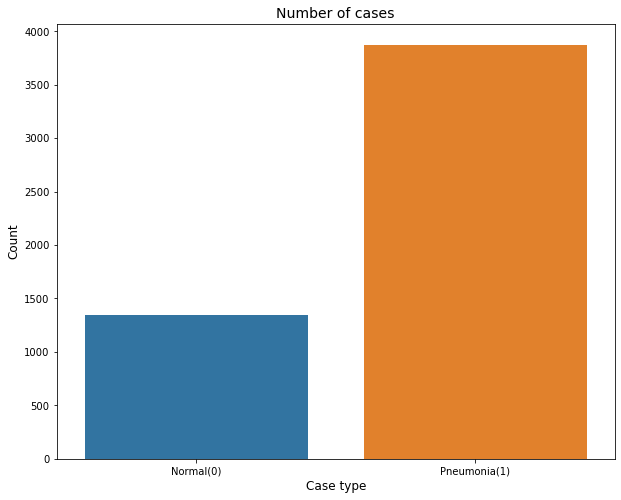

In [ ]:
# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

# Data  Augmentation

In [ ]:
img_width, img_height = 150, 150
epochs = 20
batch_size = 16
total_train=train_data.shape[0]

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [ ]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),classes = ["NORMAL", "PNEUMONIA"],
    batch_size=batch_size,
    class_mode='categorical')

Found 5216 images belonging to 2 classes.


In [ ]:
val_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,classes = ["NORMAL", "PNEUMONIA"],
    class_mode='categorical')

Found 16 images belonging to 2 classes.


In [ ]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

# Model

In [ ]:
base_model=VGG16(include_top=False, input_shape=(150,150,3),pooling='avg',weights='imagenet')

In [ ]:
model = Sequential()
model.add(base_model)
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation = 'softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 514       
Total params: 14,846,530
Trainable params: 14,846,530
Non-trainable params: 0
_________________________________________________________________


In [ ]:
base_model.trainable=False

In [ ]:
model.compile(loss='binary_crossentropy',
                  optimizer= RMSprop(0.0001),
                  metrics=['accuracy'])

In [ ]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 514       
Total params: 14,846,530
Trainable params: 131,842
Non-trainable params: 14,714,688
_________________________________________________________________
None


# Fit Training

In [ ]:
history=model.fit_generator(
    train_generator,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_generator)

Epoch 1/20
326/326 [==============================] - 605s 2s/step - loss: 0.3850 - accuracy: 0.8188 - val_loss: 0.3646 - val_accuracy: 0.7500
Epoch 2/20
326/326 [==============================] - 591s 2s/step - loss: 0.2513 - accuracy: 0.9022 - val_loss: 0.3647 - val_accuracy: 0.7500
Epoch 3/20
326/326 [==============================] - 592s 2s/step - loss: 0.2193 - accuracy: 0.9093 - val_loss: 0.3142 - val_accuracy: 0.8750
Epoch 4/20
326/326 [==============================] - 591s 2s/step - loss: 0.2030 - accuracy: 0.9199 - val_loss: 0.3336 - val_accuracy: 0.8125
Epoch 5/20
326/326 [==============================] - 644s 2s/step - loss: 0.1900 - accuracy: 0.9260 - val_loss: 0.2818 - val_accuracy: 0.8750
Epoch 6/20
326/326 [==============================] - 592s 2s/step - loss: 0.1891 - accuracy: 0.9243 - val_loss: 0.3391 - val_accuracy: 0.8125
Epoch 7/20
326/326 [==============================] - 591s 2s/step - loss: 0.1745 - accuracy: 0.9356 - val_loss: 0.3248 - val_accuracy: 0.8125

# Plots of Model

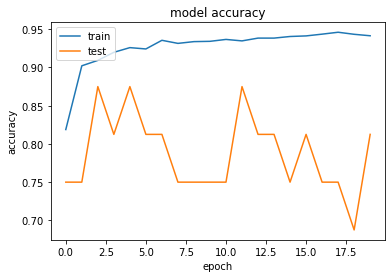

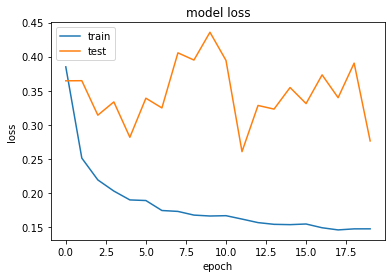

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_test=[]
X_test=[]

test_normal=Path("../chest_xray/chest_xray/test/NORMAL") 
normal = test_normal.glob('*.jpeg')
for i in normal:
    img = cv2.imread(str(i))
#     print("normal",img)
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    try:
        img = cv2.resize(img, (150,150))
    except Exception as e:
        print(str(e))
    X_test.append(img)
    label = to_categorical(0, num_classes=2)
    y_test.append(label)

test_pneumonia = Path("../chest_xray/chest_xray/test/PNEUMONIA")
pneumonia = test_pneumonia.glob('*.jpeg')
for i in pneumonia:
    img = cv2.imread(str(i))
#     print("pneumonia",img)
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    try:
        img = cv2.resize(img, (150,150))
    except Exception as e:
        print(str(e))
    X_test.append(img)
    label = to_categorical(1, num_classes=2)
    y_test.append(label)    
   
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
# Get predictions
pred = model.predict(X_test)
pred = np.argmax(pred, axis=1) 
y_true = np.argmax(y_test, axis=-1)

<Figure size 432x288 with 0 Axes>

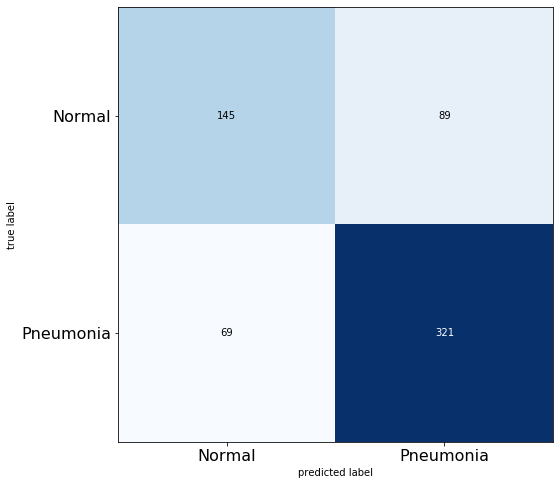

In [ ]:
cm  = confusion_matrix(y_true, pred)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [ ]:
tn, fp, fn, tp = cm.ravel()

accuracy = accuracy_score(y_true, pred)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1_score = (2*precision*recall)/(precision+recall)

print("Accuracy of the model is {:.2f}".format(accuracy))
print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("f1_score of the model is {:.2f}".format(f1_score))

Accuracy of the model is 0.75
Recall of the model is 0.82
Precision of the model is 0.78
f1_score of the model is 0.80


In [ ]:
# show a nicely formatted classification report
print(classification_report(y_true,pred, target_names= ['Normal(0)', 'Pneumonia(1)']))

              precision    recall  f1-score   support

   Normal(0)       0.68      0.62      0.65       234
Pneumonia(1)       0.78      0.82      0.80       390

    accuracy                           0.75       624
   macro avg       0.73      0.72      0.72       624
weighted avg       0.74      0.75      0.74       624

